In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, ColorJitter
import torch.optim as optim


In [19]:

# Set random seed for reproducibility
torch.manual_seed(42)


# Part I: Data Augmentation


## Exercise 1: Implement Basic Data Augmentation


In [20]:
# Part I: Data Augmentation
def add_gaussian_noise(image, mean=0., std=0.03):  
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)

# Define the normalization parameters for CIFAR-10
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD = (0.2470, 0.2435, 0.2616)

# Define basic transformations with proper normalization
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

# Define augmented transformations with better parameters and order
augmented_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    ColorJitter(
        brightness=0.2,  
        contrast=0.2,   
        saturation=0.2  
    ),
    transforms.Lambda(add_gaussian_noise),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)  
])


In [21]:

# Load CIFAR-10 dataset
trainset_basic = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=basic_transform)


Files already downloaded and verified


In [22]:

trainset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=augmented_transform)


Files already downloaded and verified


In [23]:

# Visualization function
def show_images(original_images, augmented_images, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    
    for i in range(num_images):
        # Show original images
        axes[0, i].imshow(original_images[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        
        # Show augmented images
        axes[1, i].imshow(augmented_images[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[1, i].set_title('Augmented')
    
    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.0942786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9100897..2.100835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9459234..1.7919855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6581874..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9802876..2.1264887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7709224

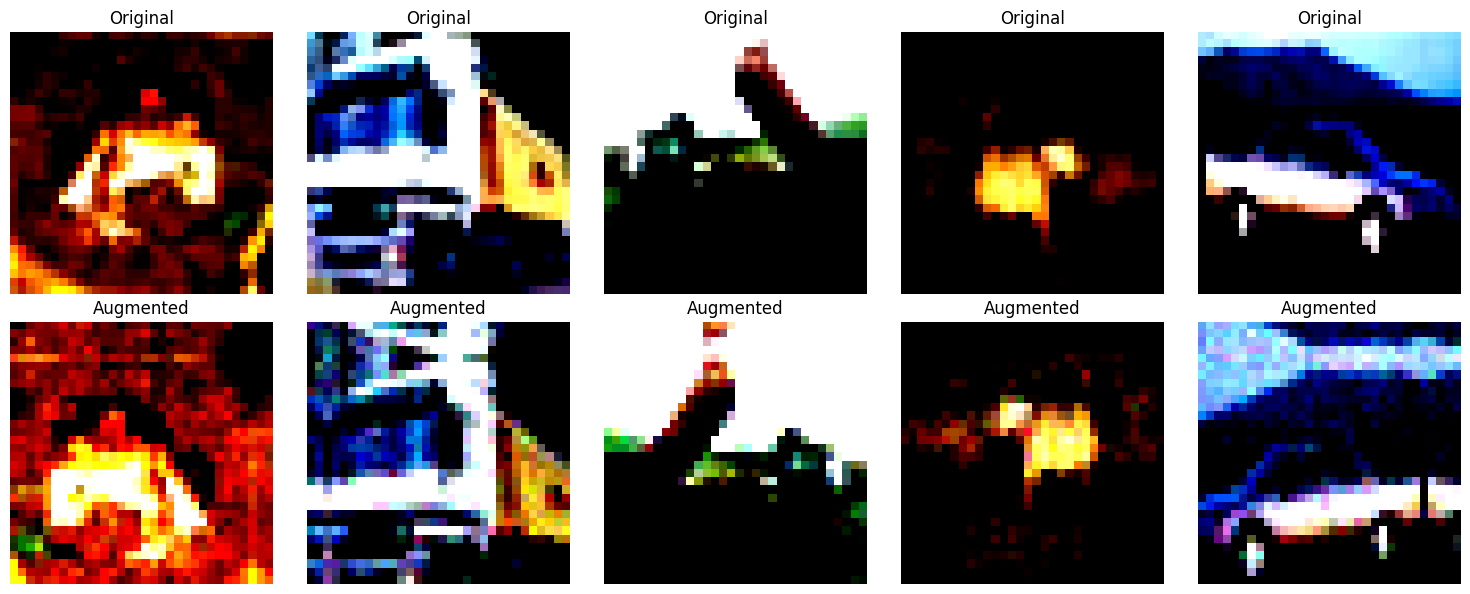

In [24]:

# Get some random training images
dataiter_basic = iter(torch.utils.data.DataLoader(trainset_basic, batch_size=5))
dataiter_augmented = iter(torch.utils.data.DataLoader(trainset_augmented, batch_size=5))

images_basic, _ = next(dataiter_basic)
images_augmented, _ = next(dataiter_augmented)

# Show images
show_images(images_basic, images_augmented)


## Exercise 2: Evaluate Impact of Data Augmentation


In [25]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer block
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional layer block
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fourth convolutional layer block
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)  # Input image 32x32 -> 2x2 after 4 max pooling layers
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Conv block 1
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        
        # Conv block 2
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        
        # Conv block 3
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        # Conv block 4
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(-1, 512 * 2 * 2)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [26]:
def train_model(model, trainloader, criterion, optimizer, device, epochs=20):
    model.train()
    train_losses = []
    val_losses = []
    
    # Create validation loader with 20% of training data
    dataset_size = len(trainloader.dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        trainloader.dataset, [train_size, val_size]
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=trainloader.batch_size,
        shuffle=True,
        num_workers=trainloader.num_workers
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=trainloader.batch_size, 
        shuffle=False,
        num_workers=trainloader.num_workers
    )

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        epoch_train_losses = []
        
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            epoch_train_losses.append(loss.item())
            
            if (i + 1) % 200 == 0:
                print(f'[{epoch + 1}, {i + 1:5d}] training loss: {running_loss / 200:.3f}')
                running_loss = 0.0
        
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch + 1} - Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')
    
    return train_losses, val_losses



In [27]:

# Evaluation function
def evaluate_model(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [28]:

# Setup for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device  = torch.device("mps" if torch.mps.is_available() else device)
print(device)


mps


In [29]:

batch_size = 32


In [30]:

# Dataloaders
trainloader_basic = torch.utils.data.DataLoader(trainset_basic, batch_size=batch_size,
                                              shuffle=True, num_workers=2, drop_last=True)

trainloader_augmented = torch.utils.data.DataLoader(trainset_augmented, batch_size=batch_size,
                                                  shuffle=True, num_workers=0, drop_last=True)


In [31]:

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=basic_transform)


Files already downloaded and verified


In [32]:

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                      shuffle=False, num_workers=2, drop_last=True)


In [33]:

# Train and evaluate models
models = {
    'augmented': SimpleCNN().to(device),
    'basic': SimpleCNN().to(device)
}



Training augmented model...
[1,   200] training loss: 2.015
[1,   400] training loss: 1.803
[1,   600] training loss: 1.731
[1,   800] training loss: 1.607
[1,  1000] training loss: 1.625
[1,  1200] training loss: 1.538
Epoch 1 - Training Loss: 1.714, Validation Loss: 1.516
[2,   200] training loss: 1.460
[2,   400] training loss: 1.422
[2,   600] training loss: 1.404
[2,   800] training loss: 1.372
[2,  1000] training loss: 1.358
[2,  1200] training loss: 1.285
Epoch 2 - Training Loss: 1.379, Validation Loss: 1.253
[3,   200] training loss: 1.276
[3,   400] training loss: 1.198
[3,   600] training loss: 1.220
[3,   800] training loss: 1.196
[3,  1000] training loss: 1.176
[3,  1200] training loss: 1.169
Epoch 3 - Training Loss: 1.203, Validation Loss: 1.119
[4,   200] training loss: 1.115
[4,   400] training loss: 1.104
[4,   600] training loss: 1.081
[4,   800] training loss: 1.050
[4,  1000] training loss: 1.047
[4,  1200] training loss: 1.037
Epoch 4 - Training Loss: 1.070, Valida

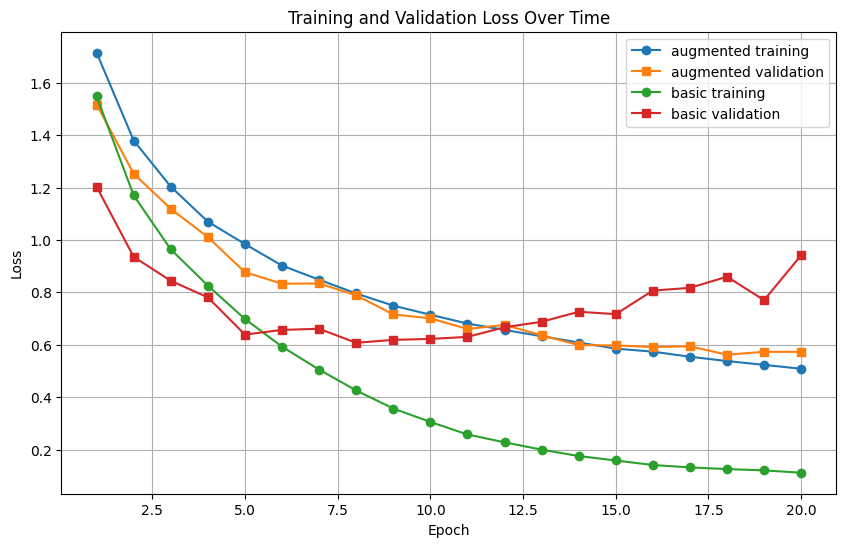

In [34]:

criterion = nn.CrossEntropyLoss()
results = {}
training_losses = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name} model...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    if model_name == 'basic':
        train_losses, val_losses = train_model(model, trainloader_basic, criterion, optimizer, device)
    else:
        train_losses, val_losses = train_model(model, trainloader_augmented, criterion, optimizer, device)
    
    training_losses[model_name] = {
        'train': train_losses,
        'val': val_losses
    }
    
    accuracy = evaluate_model(model, testloader, device)
    results[model_name] = accuracy
    print(f'{model_name.capitalize()} Model Test Accuracy: {accuracy:.2f}%')

# Update the plotting code to show both training and validation losses:
plt.figure(figsize=(10, 6))
for model_name, losses in training_losses.items():
    plt.plot(range(1, len(losses['train']) + 1), losses['train'], 
             marker='o', label=f'{model_name} training')
    plt.plot(range(1, len(losses['val']) + 1), losses['val'], 
             marker='s', label=f'{model_name} validation')

plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

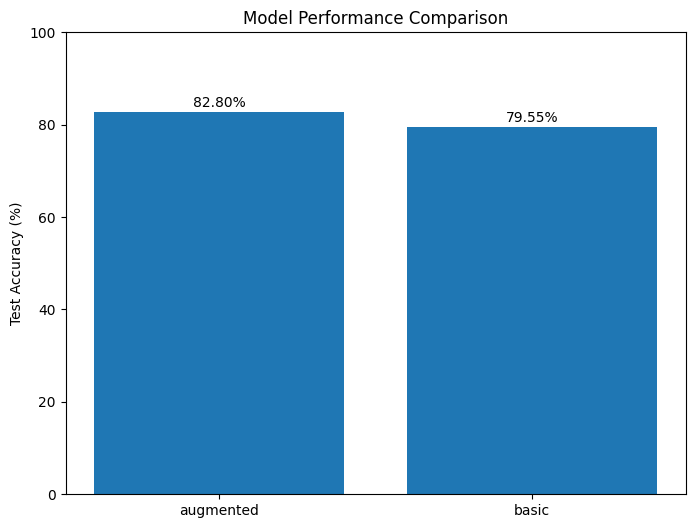

In [35]:

# Plot results
plt.figure(figsize=(8, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Performance Comparison')
plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(results.values()):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center')
plt.show()